# Minnesota potential

This notebook is dedicated to the Minnesota (MN) potential. It creates the figures in the manuscript associated with this potential.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")
output_dir = "./output"

import numpy as np
import matplotlib.pyplot as plt

from Potential import Potential
from Channel import Channel
from ScatteringExp import ScatteringExp
from Grid import Grid

from scipy.special import factorial2, spherical_jn
from plots.rc_params import *
from string import ascii_lowercase as alphabet

## Visualization of the potential (Figure 5)

Setting up training and validation sets:

In [2]:
from constants import hbarc, cm
channel = Channel(S=0, L=0, LL=0, J=0, channel=0)
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
potential = Potential(channel, **potentialArgs)
np.random.seed(123)
param_samples = {
    "training": potential.getLecsSample({"V0": (0, 400), "V1": (-400, 0)}, n=25),
    "validation": potential.getLecsSample({"V0": (0, 400), "V1": (-400, 0)}, n=1250)
}

Create figure of the Minnesota potential's (affine) parameter space:

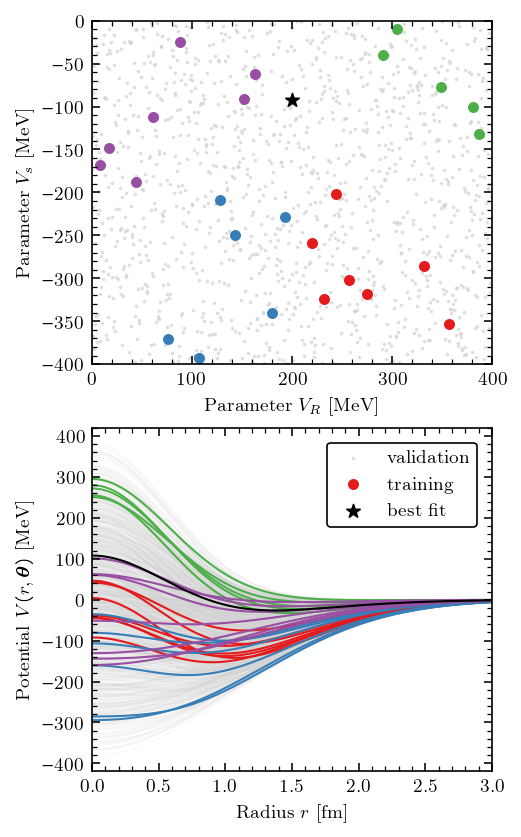

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(8.6*cm,14*cm), constrained_layout=True)
for index, lbl in enumerate(("validation", "training")):
    # randomly sample the 2d parameter space
    # we use 1250 random samples for validation and 25 for training
    param_samples_all = param_samples[lbl]
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    size_marker = [1, 20][index]
    size_line = [0.6, 1.0][index]
    alpha_lines = (0.1, 1.)[index]
        
    # left panel: parameter space
    masks = []
    masks.append(np.logical_and(param_samples_plot[:, 0] > 200, param_samples_plot[:, 1] < -200))
    masks.append(np.logical_and(param_samples_plot[:, 0] < 200, param_samples_plot[:, 1] < -200))
    masks.append(np.logical_and(param_samples_plot[:, 0] > 200, param_samples_plot[:, 1] > -200))
    masks.append(np.logical_and(param_samples_plot[:, 0] < 200, param_samples_plot[:, 1] > -200))
    
    if index == 1:
        alpha = 1 
        label = "training"
    else:
        alpha = 0.6
        label = "validation"

    for i_quadrant in range(4):
        color = colors[i_quadrant] if index == 1 else "lightgray"
        axs[0].scatter(param_samples_plot[masks[i_quadrant],0], param_samples_plot[masks[i_quadrant],1], 
                       alpha=alpha, color=color, s=size_marker, label=label if i_quadrant == 0 else "")

    # right panel: potential V(r)
    grid_plot = np.linspace(0, 4, 200)
    for i_quadrant in range(4): 
        mask = masks[i_quadrant]
        color = colors[i_quadrant] if index == 1 else "lightgray"
        add_lbl_to_legend = True if i_quadrant == 1 else False
        for ilec, lec_sample in enumerate(param_samples_all):
            if not mask[ilec]: 
                continue 
            if add_lbl_to_legend:
                label = ("validation", "training")[index]  
                add_lbl_to_legend = False
            else: 
                label = ""
            vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
            axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines, label=label)
        
# plot best_fit value
axs[0].scatter(potential.lecBaseValues["V0"], potential.lecBaseValues["V1"], 
               color="k", s=45, marker="*", label="best fit")
vr = hbarc * potential.eval(r=grid_plot, lecs=potential.lecBaseValues)
axs[1].plot(grid_plot, vr, color="k", lw=size_line, alpha=alpha_lines, label="MN potential")

# axis labels and more
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(0,400)
axs[0].set_ylim(-400,0)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")
axs[1].legend(*axs[0].get_legend_handles_labels())
fig.savefig(f"{output_dir}/minnesota_parameter_space_quadrants.png", dpi=200)

Alternatively (not shown in the manuscript), here's a version with less details:

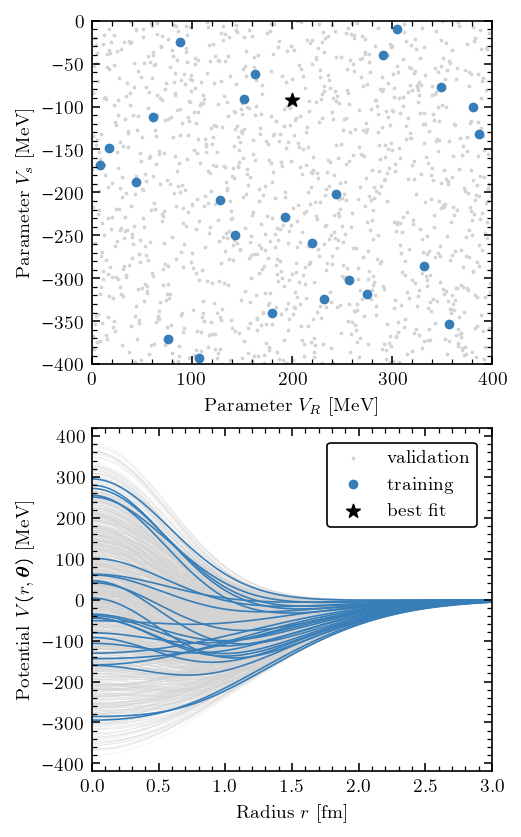

In [4]:
from constants import hbarc, cm
fig, axs = plt.subplots(2, 1, figsize=(8.6*cm,14*cm), constrained_layout=True)
np.random.seed(123)

for index, lbl in enumerate(("validation", "training")):
    param_samples_all = param_samples[lbl]
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    color = ("lightgray", colors[1])[index]
    size = [1, 15][index]
    axs[0].scatter(param_samples_plot[:,0], param_samples_plot[:,1], color=color, s=size, label=("validation", "training")[index])
    
    grid_plot = np.linspace(0, 4, 200)
    size = [1.2, 8][index]
    for lec_sample in param_samples_all:
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size/10)

axs[0].scatter(potential.lecBaseValues["V0"], 
               potential.lecBaseValues["V1"], color="k", s=45, marker="*", label="best fit")
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(0,400)
axs[0].set_ylim(-400,0)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")
axs[1].legend(*axs[0].get_legend_handles_labels())
fig.savefig(f"{output_dir}/minnesota_parameter_space.png", dpi=200)

## Testing: solve Schrödinger equation using Runge Kutta

In [5]:
l = 0
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

E_MeV = 50 # MeV
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

# generate training data
rmatch = 12
rmin = 1e-12 
grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
            type="linear", test=False) 

phase shifts: 16.827887973099042 16.827887937559247 3.5539795106842575e-08


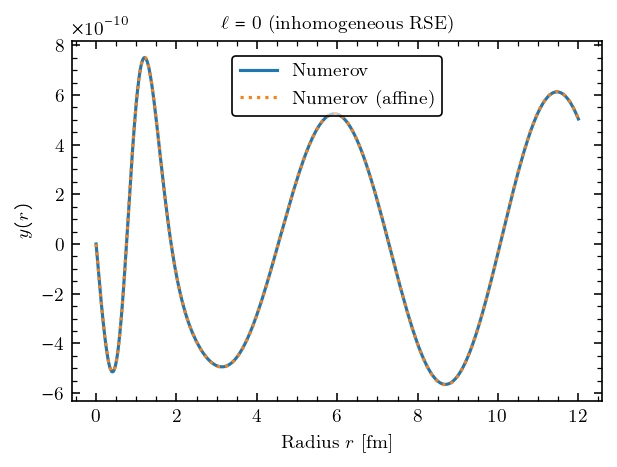

In [6]:
from RseSolver import RseSolver
solver = RseSolver(scattExp, grid, inhomogeneous=True)
kwargs = dict(lecList=testingLecList, asympParam="K", matching=True)
scattSols_numerov_affine = solver.solve(method="Numerov_affine", **kwargs)
scattSols_numerov = solver.solve(method="Numerov", **kwargs)
scattSols_rk45 = solver.solve(method="RK45", **kwargs)

pr = grid.points * scattExp.p
plt.figure(figsize=(4,3))
plt.plot(grid.points, np.real(scattSols_numerov[0].u-scattSols_rk45[0].u), label="Numerov")
plt.plot(grid.points, np.real(scattSols_numerov_affine[0].u-scattSols_rk45[0].u), 
         ls=":", label="Numerov (affine)")
# plt.plot(grid.points, greedy_grom.simulate([[1,200, -91.85]])[:,0] - scattSols_rk45[0].u, label="Numerov")
plt.xlabel("Radius $r$ [fm]")
plt.ylabel("$y(r)$")
# plt.xlim(-0.1,0.1)
rse_lbl = "inhomogeneous" if solver.inhomogeneous else "homogeneous"
plt.title(f"$\\ell = {l}$ ({rse_lbl} RSE)")
plt.legend()

a = scattSols_numerov[0].Lmatrix.phaseShift
b = scattSols_rk45[0].Lmatrix.phaseShift
print("phase shifts:", a, b, np.abs(a-b))

## Illustration of the greedy algorithm in 1D (Figure 6)

In [7]:
from NumerovEmulator import MatrixNumerovROM
inhomogeneous = True
grid = Grid(rmin, rmatch, numIntervals=1, 
            numPointsPerInterval=1000,
            type="linear", test=False) 
args = dict(scattExp=scattExp, 
            grid=grid, 
            free_lecs={"V1": (-400, 0)}, 
            num_snapshots_init=20, 
            num_snapshots_max=200, 
            approach="pod", 
            pod_rcond=1e-2, 
            init_snapshot_lecs=None,
            greedy_max_iter=3, 
            mode="linear",
            inhomogeneous=inhomogeneous,
            seed=10203
            )
pod_grom = MatrixNumerovROM(emulator_training_mode="grom", **args)
# greedy_lspg = MatrixNumerovROM(emulator_training_mode="lspg", **args)
# outp = pod_grom.simulate([[1, 200, -91.85]], which="all")
outp = pod_grom.emulate([[1, 200, -91.85]], which="all")

testing
using 3 out of 20 POD modes in total: compression rate is 85.0 %


In [8]:
from RseSolver import ScatteringSolution
scattSol = ScatteringSolution(scattExp=scattExp, 
                            vr=None,
                                grid=grid, 
                                f=outp[:,0], 
                                fprime=None,
                                f_lbl=("chi" if inhomogeneous else "u"),
                                anc=1./scattExp.p,
                                Llbl="K",
                                matching=True)
scattSol.phaseShift

17.25759744435708

In [9]:
scattSol.Lmatrix.valueAs("K")

0.3106536445878792

In [10]:
sim_delta = pod_grom.simulate([[1, 200, -91.85]], which="delta")
emu_delta = pod_grom.emulate([[1, 200, -91.85]], which="delta")
print(sim_delta)
print(emu_delta)
print(sim_delta - emu_delta)

[16.82788797]
[17.25759744]
[-0.42970947]


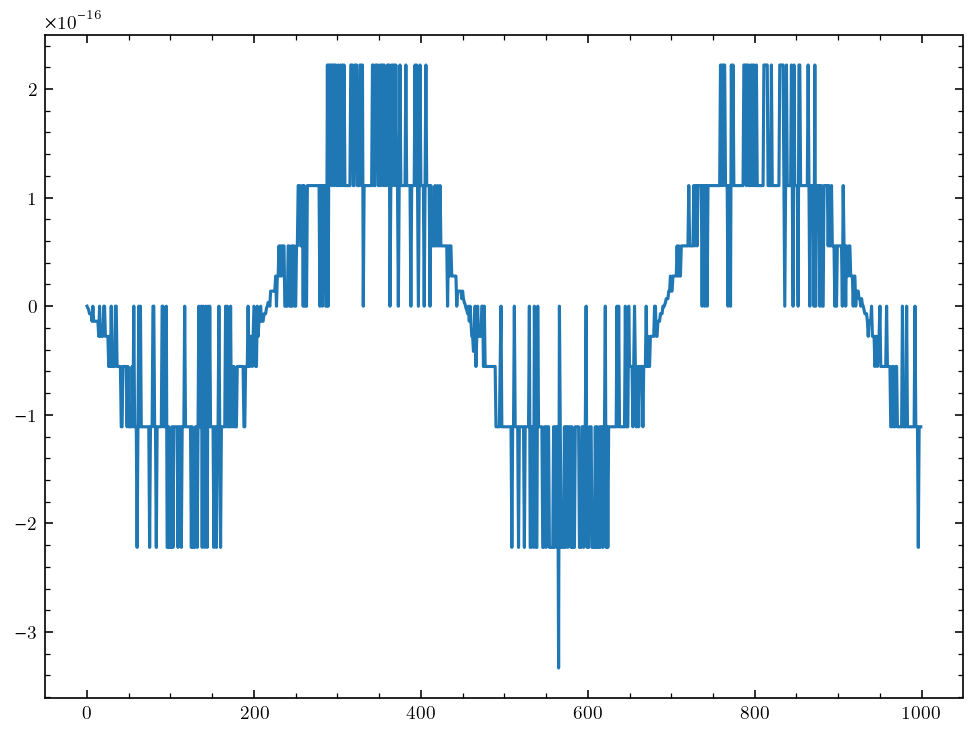

In [11]:
plt.plot(pod_grom.emulate([[1, 200, -91.85]], which="u")[:,0] - scattSol.u)

In [12]:
from NumerovEmulator import MatrixNumerovROM
grid = Grid(rmin, rmatch, numIntervals=1, 
            numPointsPerInterval=1000,
            type="linear", test=False) 
args = dict(scattExp=scattExp, 
            grid=grid, 
            free_lecs={"V1": (-400, 0)}, 
            num_snapshots_init=2, 
            num_snapshots_max=200, 
            approach="greedy", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=3, 
            mode="linear",
            # inhomogeneous=False,
            seed=10203
            )
greedy_grom = MatrixNumerovROM(emulator_training_mode="grom", **args)
greedy_lspg = MatrixNumerovROM(emulator_training_mode="lspg", **args)

testing
snapshot idx already included in basis: {35, 149}
now greedily improving the snapshot basis:
	iteration #1 of max 3:
	available candidate snapshot idx to be added: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 1

In [13]:
print(greedy_grom.simulate([[1, 200, -91.85]], which="delta"))
print(greedy_grom.emulate([[1, 200, -91.85]], which="delta"))

[16.82788797]
[16.82457789]


In [14]:
greedy_grom.simulate([[1, 200, -91.85]], which="delta") - greedy_grom.emulate([[1, 200, -91.85]], which="delta")

array([0.00331008])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


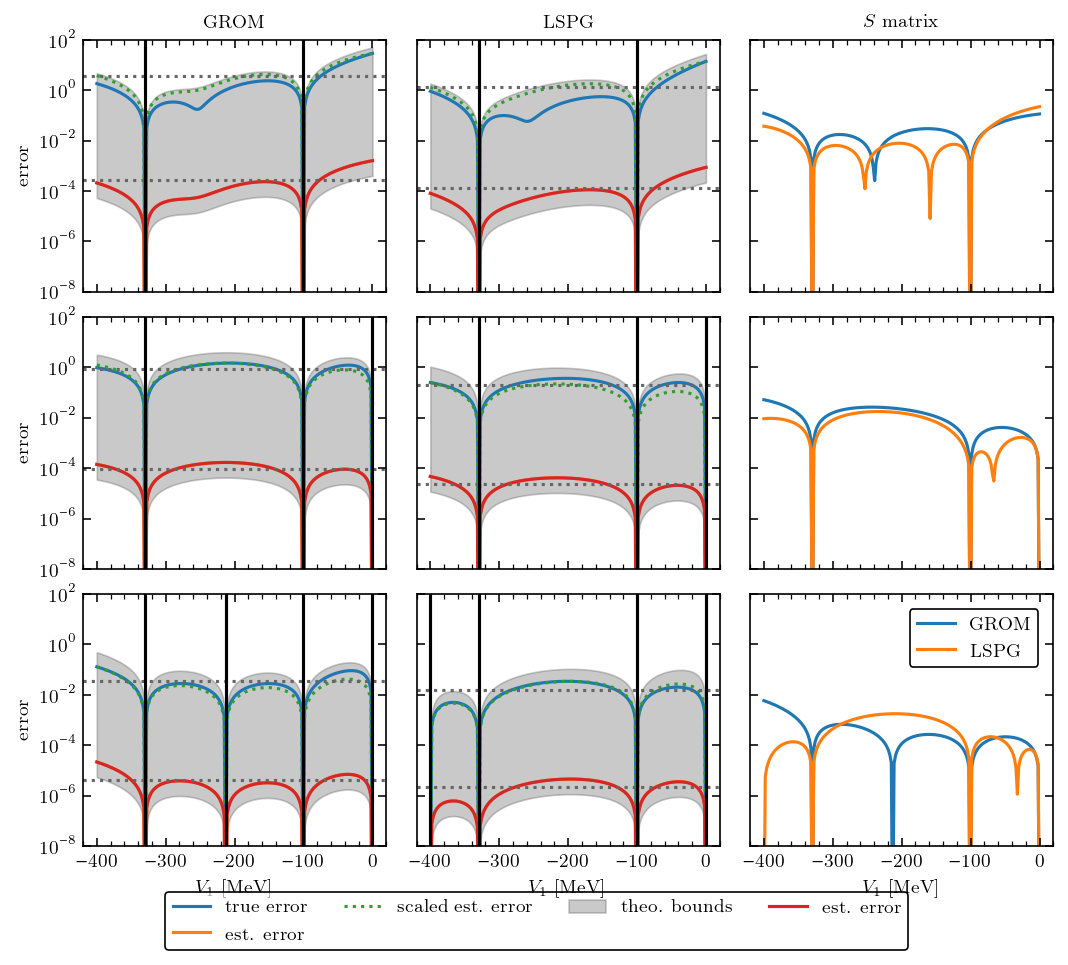

In [15]:
from constants import cm
mpl.rcParams['figure.constrained_layout.use'] = False
num_iter = len(greedy_lspg.greedy_logging)
V0_arr = greedy_lspg.lec_all_samples[:,2]
fig, axs = plt.subplots(num_iter, 3, sharex=True, sharey=True,
                        figsize=(18*cm,16*cm), layout=None)

plt.subplots_adjust(left=0.07, right=0.99, 
                    top=0.96, bottom=0.1, 
                    wspace=0.1, hspace=0.1)
for ax in axs[-1,:]:
    ax.set_xlabel("$V_1$ [MeV]")
for ax in axs[:, 0]:
    ax.set_ylabel("error")
for ax, title in zip(axs[0,:], ("GROM", "LSPG", "$S$ matrix")):
    ax.set_title(title)

axs[0,0].set_ylim(1e-8, 1e2)
# axs[0,0].set_xlim(V0_arr[0], V0_arr[-1])

for niter in range(num_iter):
    for irom_lbl, rom_lbl in enumerate(("grom", "lspg")):
        rom = greedy_grom if rom_lbl == "grom" else greedy_lspg
        ax = axs[niter, irom_lbl]
        [snapshot_idxs, fom_sol, emulated_sol, 
        romErrors, realErrors, estErrBounds,
        coercivity_constant, 
        ab_emulated, ab_simulated, error_est_delta] = rom.greedy_logging[niter]
        ax.semilogy(V0_arr, realErrors, label=f"true error")
        ax.semilogy(V0_arr, romErrors, ls="-", label=f"est. error")
        ax.semilogy(V0_arr, coercivity_constant*romErrors, 
                    ls=":", label=f"scaled est. error")
        
        # ax.semilogy(V0_arr, estErrBounds[:,0], label=f"lower bound")
        # ax.semilogy(V0_arr, estErrBounds[:,1], label=f"upper bound")
        ax.fill_between(V0_arr, estErrBounds[:,0], estErrBounds[:,1], 
                        alpha=0.3, color='0.3',
                        zorder=0, label="theo. bounds")
        ax.semilogy(V0_arr, romErrors, ls="-", label=f"est. error")
        delta_rom = np.arctan2(ab_emulated[1,:], ab_emulated[0,:])
        delta_fom = np.arctan2(ab_simulated[1,:], ab_simulated[0,:])
        axs[niter, 2].semilogy(V0_arr, np.abs(delta_rom - delta_fom), 
                               label=rom_lbl.upper())
        for err in (romErrors, realErrors):
            ax.axhline(np.mean(err), ls=":", c='0.4', label="")
            # ax.set_title(f"Estimated mean error: {np.mean(realErrors):.2e}")

        for idx in snapshot_idxs:
            ax.axvline(V0_arr[idx], c="k", label="")
    
    axs[-1,0].legend(bbox_to_anchor =(0.5, 0.02), loc='center', ncol=4, 
                     bbox_transform=fig.transFigure)
    # axs[0,0].legend(loc='lower left', ncol=4, bbox_to_anchor =(1.5,2.65))
    axs[-1,-1].legend(loc='best', ncol=1)
    fig.savefig(f"greedy_MN_potential_1S0.pdf")

In [16]:
for n, nn in zip(V0_arr,np.rad2deg(np.arctan2(ab_simulated[1,:],ab_simulated[0,:]))):
                 print(n,nn)

-400.0 153.91069553003297
-397.9899497487437 153.05442807078697
-395.97989949748745 152.19521053758191
-393.96984924623115 151.33313380722333
-391.9597989949749 150.46829154698187
-389.9497487437186 149.6007800966237
-387.9396984924623 148.73069834241363
-385.92964824120605 147.85814758149817
-383.91959798994975 146.98323137841453
-381.90954773869345 146.10605541283823
-379.8994974874372 145.22672732014976
-377.8894472361809 144.34535652362533
-375.8793969849246 143.46205406039257
-373.86934673366835 142.57693240037844
-371.85929648241205 141.69010525927803
-369.8492462311558 140.8016874060488
-367.8391959798995 139.91179446553477
-365.8291457286432 139.0205427167961
-363.81909547738695 138.12804888759462
-361.80904522613065 137.2344299461294
-359.7989949748744 136.3398028902622
-357.7889447236181 135.44428453537995
-355.7788944723618 134.5479913009664
-353.76884422110555 133.65103899749116
-351.75879396984925 132.75354261325214
-349.74874371859295 131.8556161028504
-347.7386934673367 

In [17]:
for n, nn in zip(V0_arr,np.rad2deg(np.arctan2(ab_emulated[1,:],ab_emulated[0,:]))):
                 print(n,nn)

-400.0 153.9106955300061
-397.9899497487437 153.05474844087885
-395.97989949748745 152.1959006553747
-393.96984924623115 151.33423565298904
-391.9597989949749 150.46983975256566
-389.9497487437186 149.6028020119239
-387.9396984924623 148.73321411864768
-385.92964824120605 147.86117027216815
-383.91959798994975 146.98676705731285
-381.90954773869345 146.11010330954235
-379.8994974874372 145.23127997213697
-377.8894472361809 144.3503999456423
-375.8793969849246 143.46756792992252
-373.86934673366835 142.58289025921573
-371.85929648241205 141.69647473062102
-369.8492462311558 140.80843042649275
-367.8391959798995 139.9188675312422
-365.8291457286432 139.02789714309242
-363.81909547738695 138.13563108135284
-361.80904522613065 137.24218168981093
-359.7989949748744 136.34766163686317
-357.7889447236181 135.45218371302218
-355.7788944723618 134.55586062645875
-353.76884422110555 133.65880479724262
-351.75879396984925 132.76112815095826
-349.74874371859295 131.8629419123711
-347.7386934673367

In [18]:
np.rad2deg(np.arctan2(ab_simulated[1,:],ab_simulated[0,:]))

array([153.91069553, 153.05442807, 152.19521054, 151.33313381,
       150.46829155, 149.6007801 , 148.73069834, 147.85814758,
       146.98323138, 146.10605541, 145.22672732, 144.34535652,
       143.46205406, 142.5769324 , 141.69010526, 140.80168741,
       139.91179447, 139.02054272, 138.12804889, 137.23442995,
       136.33980289, 135.44428454, 134.5479913 , 133.651039  ,
       132.75354261, 131.8556161 , 130.95737218, 130.0589221 ,
       129.16037547, 128.26184004, 127.36342152, 126.46522337,
       125.56734662, 124.66988971, 123.77294829, 122.87661509,
       121.98097972, 121.08612857, 120.19214462, 119.29910734,
       118.40709255, 117.51617233, 116.62641486, 115.73788439,
       114.8506411 , 113.96474105, 113.08023609, 112.19717381,
       111.31559749, 110.43554605, 109.55705401, 108.68015146,
       107.80486407, 106.93121305, 106.05921512, 105.1888826 ,
       104.32022331, 103.45324067, 102.58793368, 101.72429697,
       100.8623208 , 100.00199114,  99.14328967,  98.28

In [19]:
np.rad2deg(np.arctan2(ab_simulated[1,:],ab_simulated[0,:])) - np.rad2deg(np.arctan2(ab_emulated[1,:],ab_emulated[0,:]))

array([ 2.68585154e-11, -3.20370092e-04, -6.90117793e-04, -1.10184577e-03,
       -1.54820558e-03, -2.02191530e-03, -2.51577623e-03, -3.02269067e-03,
       -3.53567890e-03, -4.04789670e-03, -4.55265199e-03, -5.04342202e-03,
       -5.51386953e-03, -5.95785884e-03, -6.36947134e-03, -6.74302044e-03,
       -7.07306571e-03, -7.35442630e-03, -7.58219376e-03, -7.75174368e-03,
       -7.85874660e-03, -7.89917764e-03, -7.86932549e-03, -7.76579975e-03,
       -7.58553771e-03, -7.32580952e-03, -6.98422234e-03, -6.55872339e-03,
       -6.04760140e-03, -5.44948751e-03, -4.76335410e-03, -3.98851323e-03,
       -3.12461356e-03, -2.17163604e-03, -1.12988857e-03,  3.51576546e-11,
        1.21708771e-03,  2.52012740e-03,  3.90757592e-03,  5.37760434e-03,
        6.92810870e-03,  8.55672135e-03,  1.02608230e-02,  1.20375556e-02,
        1.38838355e-02,  1.57963664e-02,  1.77716541e-02,  1.98060198e-02,
        2.18956152e-02,  2.40364363e-02,  2.62243381e-02,  2.84550494e-02,
        3.07241867e-02,  

In [20]:
16.82788797309*2

33.65577594618

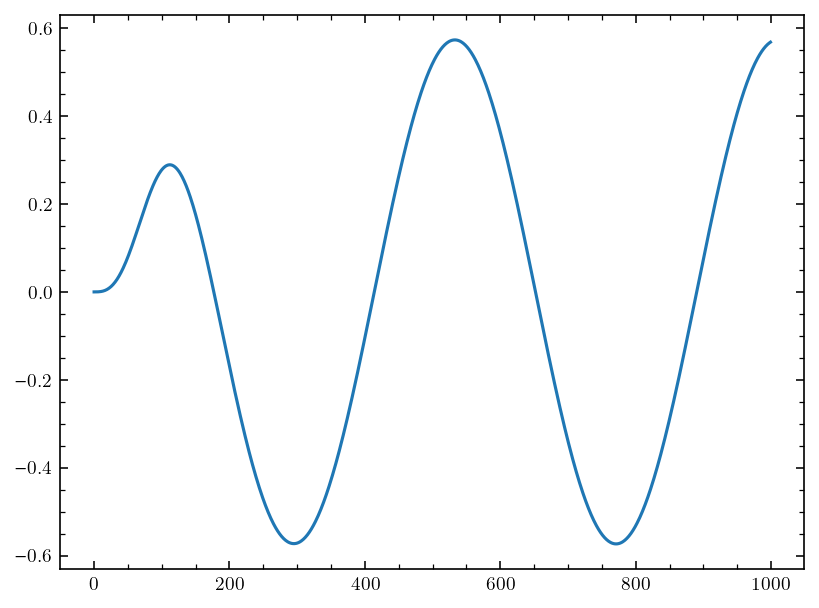

In [21]:
plt.plot(greedy_grom.simulate([[1,200, -91.85]]))